In [1]:
import sys
sys.path.insert(0, "../..")

import jax
import jax.numpy as jnp

import jax.scipy
import jax.scipy.special

from tqdm import tqdm
from functools import partial

import module.samplers
import module.wavefunctions
import module.misc.cutoffs as cutoffs

import flax.linen as nn

import optax
import numpy as np
from matplotlib import pyplot as plt

import netket.nn.activation
import pickle

import netket as nk

from scipy.sparse.linalg import eigsh

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/ewonisch/NeuralQuantumStates/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
key = jax.random.PRNGKey(0)

## Hamiltonian

$$
H = -h\sum_{i}S_i^{(x)} + J \sum_{<i,j>} S_i^{(z)} S_j^{(z)}
$$

In [59]:
# Define a grid
L = 4
g = nk.graph.Hypercube(length=L, n_dim=2, pbc=True)

# The number of sites (called nodes):
print("g.n_nodes:", g.n_nodes)
# You can iterate through the nodes:
print("g.nodes:", [node for node in g.nodes()])
# You can check the number of edges:
print("g.n_edges:", g.n_edges)
# You can iterate through the edges, which are stored as a 2-tuple with the start and end node:
print("g.edges:", g.edges())

# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero 
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)

# This creates an empty operator (or zero) to which you can add others.
h = 1.
J = 1.

hamiltonian = nk.operator.LocalOperator(hi)

# now add all terms acting on single sites
for site in g.nodes():
    hamiltonian = hamiltonian - h* nk.operator.spin.sigmax(hi, site)

    # now add all terms acting on multiple sites
for (i,j) in g.edges():
    hamiltonian = hamiltonian + J * nk.operator.spin.sigmaz(hi, i) @ nk.operator.spin.sigmaz(hi, j)


hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()

g.n_nodes: 16
g.nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
g.n_edges: 32
g.edges: [(3, 7), (12, 13), (8, 9), (8, 12), (2, 14), (13, 14), (4, 5), (5, 6), (4, 8), (12, 15), (5, 9), (14, 15), (3, 15), (8, 11), (0, 1), (9, 10), (1, 2), (0, 4), (9, 13), (10, 11), (1, 5), (10, 14), (6, 7), (6, 10), (4, 7), (0, 3), (0, 12), (2, 3), (1, 13), (2, 6), (11, 15), (7, 11)]


In [60]:
ha = hamiltonian.to_sparse()
e_gs, psi_gs = eigsh(ha, k=1, which = "SA")
E_f = e_gs[0]
psi_gs = psi_gs.reshape(-1)

In [61]:
def calc_H_loc(orbital, parameters, samples):
    eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(samples)
    
    logpsi_sigma = orbital.calc_logpsi(parameters, samples)
    logpsi_eta = orbital.calc_logpsi(parameters, eta)
    logpsi_sigma = jnp.expand_dims(logpsi_sigma, -1) 
    
    res = jnp.sum(H_sigmaeta * jnp.exp(logpsi_eta - logpsi_sigma), axis=-1)
    
    return res

## Construct Neural Network

In [62]:
def act(x):
    return nn.softplus(x)

In [63]:
class NN(nn.Module):
    """
    Constructs a neural network.

    possible activation functions:
    netket.nn.activation.log_cosh(x)
    nn.softplus()
    """
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10, name="dense1", param_dtype="float64", bias_init=jax.random.normal)(x)
        x = act(x)
        x = nn.Dense(10, name="dense2", param_dtype="float64", bias_init=jax.random.normal)(x)
        x = act(x)
        x = nn.Dense(1, name="dense3", param_dtype="float64", bias_init=jax.random.normal)(x)

        return jnp.squeeze(x)

## Construct Ansatz

In [64]:
class Ansatz(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__(input_shape = (g.n_nodes,))

        self.nn = NN()


    def init_param(self, key):
        nn_param = self.nn.init(key, jnp.empty((g.n_nodes,)))

        return {"nn": nn_param}
    
    
    def calc_logpsi(self, parameters, x):
        logpsi = jnp.log(self.nn.apply(parameters["nn"], x) + 0.j)

        return logpsi

In [65]:
ansatz = Ansatz()
key, _ = jax.random.split(key)
param = ansatz.init_param(key)

## Sampler

In [66]:
class FlipSampler(module.samplers.MCMC):
    def propose(self, key, element):
        subkey, _ = jax.random.split(key)

        mask = jnp.ones((g.n_nodes))
        for i in range(self.variance):
            index = jax.random.randint(key, (), 0, g.n_nodes)
            key, _ = jax.random.split(key)
            mask = mask.at[index].multiply(-1)

        proposal = element * mask

        return subkey, proposal
sampler = FlipSampler(ansatz, 1)
subsampling = g.n_nodes
def get_samples(N):
    """
    Returns decorrelated samples.
    """
    samples, ratio = sampler.sample(key, param, 2*jax.random.randint(key, (g.n_nodes,), 0, 2)-1 + 0., N*subsampling)
    return samples[0:-1:subsampling], ratio

## Optimisation

In [67]:
@partial(jax.jit, static_argnames=['orbital'])
def calc_grad_E(orbital, parameters, samples):
    """
    Calculates the gradient of the energy and the energy itself on a batch of samples.
    """

    E_loc = calc_H_loc(orbital, parameters, samples)
    E = jnp.mean(E_loc.real)
    dE = jnp.std(E_loc.real)

    logpsi_red = lambda parameters: jnp.conjugate(orbital.calc_logpsi(parameters, samples))
    y, v = netket.jax.vjp(logpsi_red, parameters)
    N = samples.shape[0]

    m = lambda tree: 2*jnp.real(tree/N)

    return jax.tree_util.tree_map(m, v(E_loc - E))[0], E, dE

def eval_S1(orbital, parameters, samples, v):
    f = lambda param: orbital.calc_logpsi(param, samples)
    N = samples.shape[0]

    a = jax.jvp(f, (parameters,), (v,))[1]
    b = netket.jax.vjp(f, parameters)[1](a)[0]
    return jax.tree_util.tree_map(lambda x: 1/N*x, b)

def eval_S2(orbital, parameters, samples, v):
    f = lambda param: orbital.calc_logpsi(param, samples)
    N = samples.shape[0]
    e = jnp.ones(N)

    a = jnp.sum(jax.jvp(f, (parameters,), (v,))[1])
    b = netket.jax.vjp(f, parameters)[1](e)[0]
    return  jax.tree_util.tree_map(lambda v: 1/N**2 * a * v, b)

@partial(jax.jit, static_argnames=['orbital'])
def eval_S(orbital, parameters, samples, v):
    s1 = eval_S1(orbital, parameters, samples, v)
    s2 = eval_S2(orbital, parameters, samples, v)
    return jax.tree_util.tree_map(lambda a,b: jnp.real(a-b), s1, s2)
eps = 1e-3

def reg_S(ansatz, param, samples, v):
    u = eval_S(ansatz, param, samples, v)
    return jax.tree_util.tree_map(lambda a,b: a + eps * b, u, v)

@jax.jit
def calc_natural_grad(param, samples):
    A = lambda v: reg_S(ansatz, param, samples, v)
    b, E, dE = calc_grad_E(ansatz, param, samples)
    return jax.scipy.sparse.linalg.cg(A, b)[0], E, dE

In [73]:
stats = {"E":[], "dE":[], "ratio":[], "N_samples": []}
param = ansatz.init_param(key)

In [75]:
N = 5000
epoch = 500

# define
optimizer = optax.sgd(learning_rate=optax.linear_schedule(0.01,1e-4, 200))

# initialise
optimizer_state = optimizer.init(param)

In [76]:
hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()
for i in tqdm(range(epoch)):
    key, _ = jax.random.split(key)
    samples, ratio = get_samples(N)
    grad, E, dE = calc_natural_grad(param, samples)
    # grad, E, dE = calc_grad_E(hamiltonian, ansatz, param, samples)

    stats["E"].append(E)
    stats["dE"].append(dE)
    stats["ratio"].append(ratio)
    stats["N_samples"].append(N)
    
    updates, optimizer_state = optimizer.update(grad, optimizer_state, param)

    param = optax.apply_updates(param, updates)

100%|██████████| 500/500 [01:35<00:00,  5.24it/s]


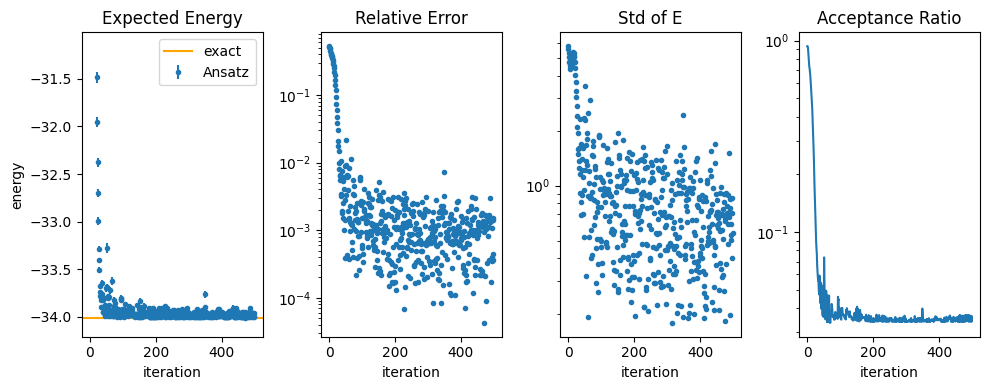

In [89]:
numpy_stats = {}
for key_ in stats.keys():
    numpy_stats[key_] = np.array(stats[key_])

f, ax = plt.subplots(1, 4, figsize = (10, 4))
i = np.arange(len(stats["E"]))

ax[0].errorbar(i, numpy_stats["E"], yerr = numpy_stats["dE"]/jnp.sqrt(numpy_stats["N_samples"]), fmt = ".", label = "Ansatz")
ax[0].set_title("Expected Energy")
ax[0].axhline(E_f, label = "exact", color = "orange")
ax[0].legend(loc = "upper right")
ax[0].set_ylim(E_f-0.2, E_f+3)
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("energy")

ax[1].scatter(i, jnp.abs(numpy_stats["E"]-E_f)/-E_f , label = "error", marker = ".")
ax[1].set_title("Relative Error")
ax[1].set_yscale("log")
ax[1].set_xlabel("iteration")
# ax[1].set_xlim(i[-20], i[-1])

ax[2].scatter(i, stats["dE"], marker = ".")
ax[2].set_title("Std of E")
ax[2].set_yscale("log")
ax[2].set_xlabel("iteration")

ax[3].plot(stats["ratio"])
# ax[3].set_ylim(0,1)
ax[3].set_title("Acceptance Ratio")
ax[3].set_xlabel("iteration")
ax[3].set_yscale("log")

f.tight_layout()

# n_param = sum(x.size for x in jax.tree_util.tree_leaves(param))


In [81]:
N = 10000
key, _ = jax.random.split(key)
samples, ratio = get_samples(N)
hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()
H_loc = calc_H_loc(ansatz, param, samples).real
print("Acceptance Ratio:\t", ratio)
print("Expected Energy:\t\t", jnp.mean(H_loc),"+/-", jnp.std(H_loc)/jnp.sqrt(N))
print("Ground Truth:\t\t\t", E_f)
print("Energy Error:\t\t", (jnp.mean(H_loc) - E_f)/jnp.abs(E_f))
print("Std of Expected Energy:\t", jnp.std(H_loc))

Acceptance Ratio:	 0.033668750000000004
Expected Energy:		 -34.00514212705418 +/- 0.0028126246893807366
Ground Truth:			 -34.01059755084618
Energy Error:		 0.00016040364430069877
Std of Expected Energy:	 0.28126246893807366


In [82]:
all_states = jnp.array([state for state in hi.states()])
psi = ansatz.calc_psi(param, all_states)

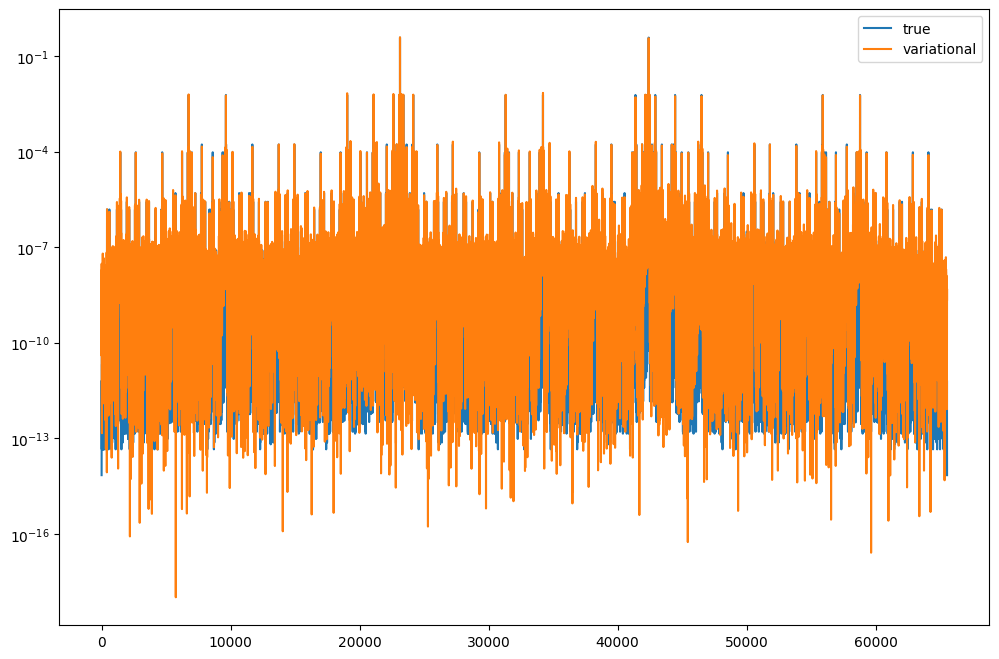

In [83]:
plt.figure(figsize=(12,8))
plt.plot(jnp.abs(psi_gs)**2, label="true")
plt.plot(jnp.abs(psi)**2/jnp.sum(jnp.abs(psi)**2), label = "variational")
plt.yscale("log")
# plt.xlim(0,1000)
plt.legend()

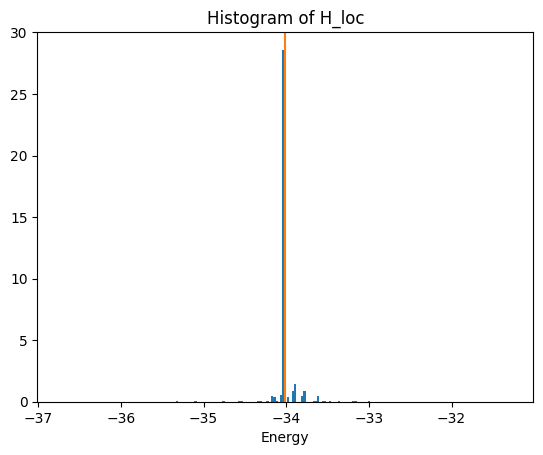

In [84]:
plt.hist(H_loc, bins=500, density=True)
plt.axvline(E_f, color = "C1")
# plt.ylim(0,20)
plt.title("Histogram of H_loc")
plt.xlabel("Energy")
plt.xlim(E_f - 3, E_f + 3)
pass

---